In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

In [ ]:
#device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu" ## Use this instead
print(f"Using {device}")

Using cpu


In [ ]:
ds = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 18680620.20it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 367565.28it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6007766.75it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21127472.59it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
loader = data.DataLoader(ds, batch_size=64, shuffle=True)

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.mean_layer = nn.Linear(64, 8)
        self.var_layer = nn.Linear(64, 8)

        self.decoder = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def forward(self, x):
        x = self.flatten(x)
        z = self.encoder(x)
        mu = self.mean_layer(z)
        var = self.var_layer(z)
        z = self.reparameterization(mu, var)
        x = self.decoder(z)
        x = x.view(-1, 1, 28, 28)
        return x, mu, var

In [ ]:
vae = VariationalAutoencoder().to(device)

def vae_loss(pred,x, mean, var):
    reconstruction_loss = F.binary_cross_entropy(pred, x, reduction='sum')
    divergence = - 0.5 * torch.sum(1+ var - mean.pow(2) - var.exp())
    return reconstruction_loss + divergence

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

Epoch 0


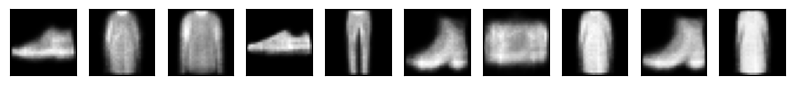

Epoch 1


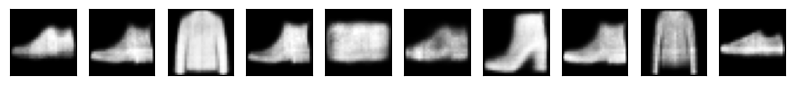

Epoch 2


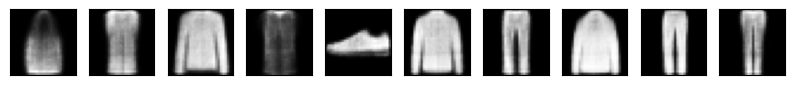

Epoch 3


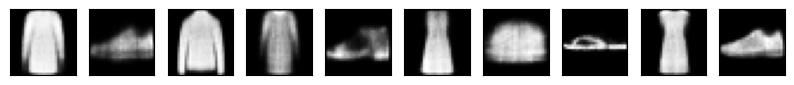

Epoch 4


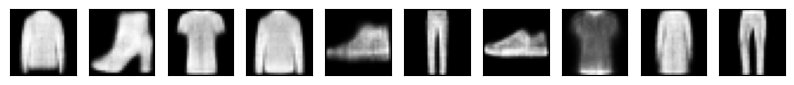

Epoch 5


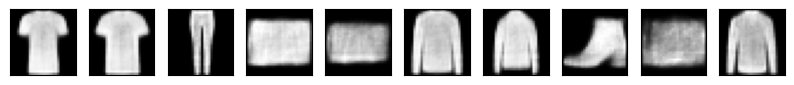

Epoch 6


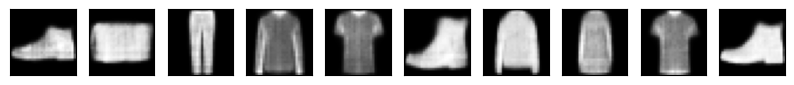

Epoch 7


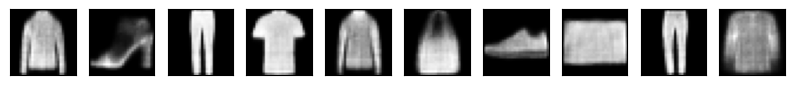

Epoch 8


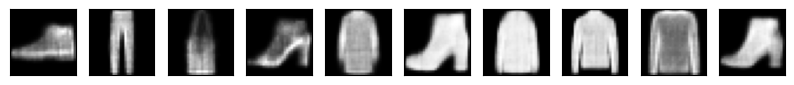

Epoch 9


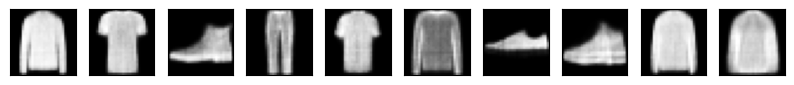

Epoch 10


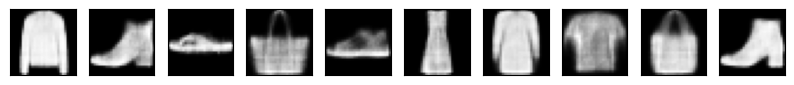

Epoch 11


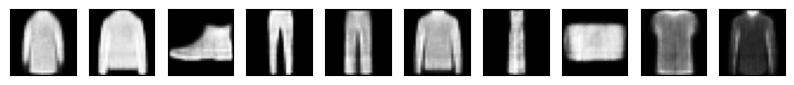

Epoch 12


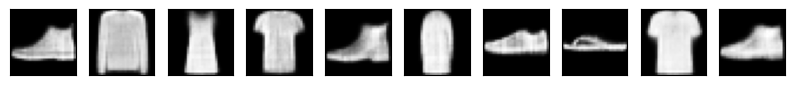

Epoch 13


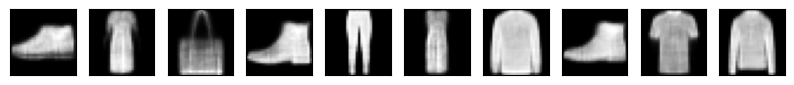

Epoch 14


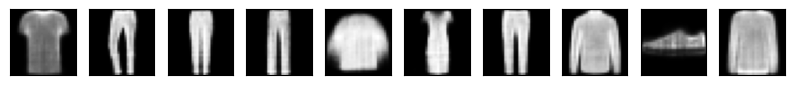

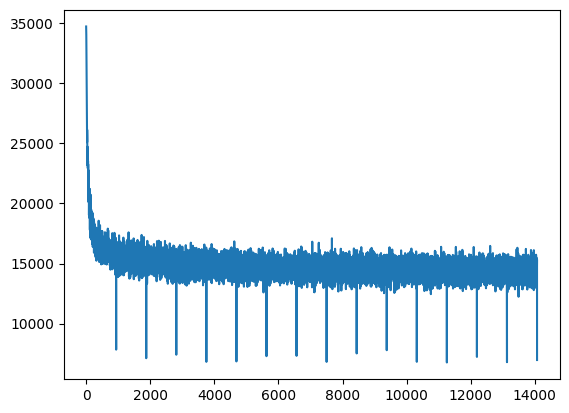

In [ ]:
epochs = 15
losses = []


for epoch in range(epochs):
    print(f'Epoch {epoch}')
    for i, (X, _) in enumerate(loader):
        X = X.to(device)
        output, mu, var = vae(X)
        loss = vae_loss(output, X, mu, var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #torch.cuda.synchronize()

        losses.append(loss.cpu().detach().numpy())

    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(output[i, 0].cpu().detach().view(28, 28, 1), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

plt.plot(losses)
plt.show()